In [1]:
#! pip install pandas

In [2]:
import os
import shutil

import matplotlib.pyplot as plt
from PIL import Image
from skimage import io
import numpy as np
from sklearn.model_selection import train_test_split
from skimage.transform import resize
import pandas as pd
import tensorflow as tf

## Read dataset

In [3]:
# Main Directory
main_dir = 'Merged_folder/'
print(f'The total number of images is {len(os.listdir(main_dir))}')

The total number of images is 825


In [4]:
# specify the img directory path
path = main_dir

# list files in img directory
files = os.listdir(path)

image_list = []

for file in files:
    # make sure file is an image
    if file.endswith(('.jpg', '.png', 'jpeg', 'tiff')):
        #img_path = path + file
        image_list.append(os.path.join(path, file))
        
print(f'Image list top 5 examples:')
image_list[:5]

Image list top 5 examples:


['Merged_folder/73001_image_2016-10-30.tiff',
 'Merged_folder/73001_image_2016-03-20.tiff',
 'Merged_folder/73001_image_2016-08-07.tiff',
 'Merged_folder/54001_image_2016-01-24.tiff',
 'Merged_folder/73001_image_2016-06-19.tiff']

# Train-Test Split

In [5]:
# Train-Test split
image_list = np.array(image_list)
x_train, x_test = train_test_split(image_list,test_size=0.2)
#x_train, x_val = train_test_split(x_train,test_size=0.1)

In [6]:
# To numpy
x_train = np.array(x_train)
#x_val = np.array(x_val)
x_test = np.array(x_test)

# Create a custom dataloader

In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Augmentation for train
train_datagen = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=False)


In [8]:
class CustomDataGen(tf.keras.utils.Sequence):
    
    def __init__(self, image_paths,
                 batch_size,
                 input_size=(224, 224, 8),
                 shuffle=True, 
                 augmentation = None):
        
        self.image_paths = image_paths
        self.batch_size = batch_size
        self.input_size = input_size
        self.shuffle = shuffle
        self.augmentation = augmentation
        
        # Length of dataset
        self.n = len(self.image_paths)
        
    # Helper function to read the image
    def __get_input(self, path, target_size):
        
        # Read the image and convert to numpy array
        image = io.imread(path)

        # Resize the image
        image_arr = resize(image,(target_size[0], target_size[1]))
        return image_arr

    # Helper function to gat a batch
    def __get_data(self, batches):
        # Generates data containing batch_size samples
        # For each image path read the image and create a batch of images
        X_batch = np.asarray([self.__get_input(x, self.input_size) for x in batches]).astype('float32')
        #print(f'The shape of the batch of images is: {X_batch.shape}')
        
        # Augmentation
        if self.augmentation:
            # prepare iterator
            X_batch = self.augmentation.flow(X_batch, batch_size=self.batch_size, shuffle=True).next()
            #print('Augmentation done!')
            
        return X_batch
    
    def __getitem__(self, index):     
        batches = self.image_paths[index * self.batch_size:(index + 1) * self.batch_size]
        X = self.__get_data(batches)  
        #print(f'The final shape is {X.shape}')
        return X
    
    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.image_paths)
            #self.image_paths.sample(frac=1).reset_index(drop=True)
    
    def __len__(self):
        return self.n // self.batch_size

In [9]:
batch_size = 8
target_size = (740, 740, 12)
traingen = CustomDataGen(x_train,
                         batch_size=batch_size, 
                         input_size=target_size, 
                         augmentation=train_datagen,
                         shuffle = True)
                         #augmentation=None)

/Users/davidrestrepo/miniforge3/envs/dengue/lib/python3.9/site-packages/keras_preprocessing/image/numpy_array_iterator.py:129: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 740, 740, 12) (12 channels).
  warnings.warn('NumpyArrayIterator is set to use the '


(1, 1, 740, 740, 12)
(1, 1, 740, 740, 12)
(1, 1, 740, 740, 12)
(1, 1, 740, 740, 12)
(1, 1, 740, 740, 12)
(1, 1, 740, 740, 12)
(1, 1, 740, 740, 12)
(1, 1, 740, 740, 12)
(1, 1, 740, 740, 12)


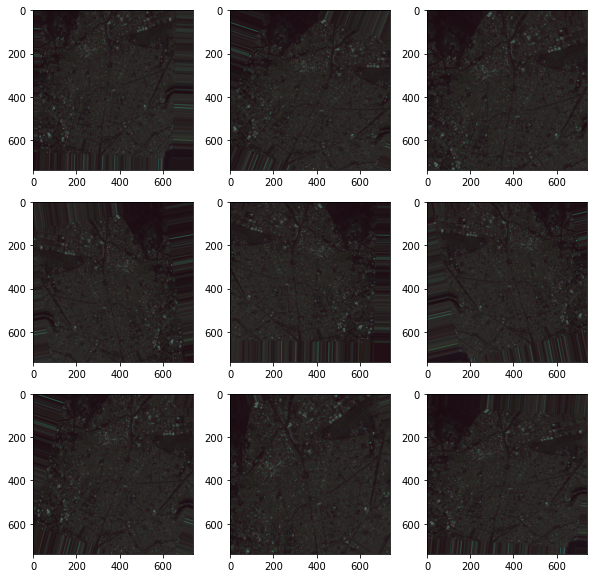

In [10]:
ax = plt. subplots(3, 3, figsize=(10,10))
for i in range(9):
    # define subplot
    plt.subplot(330 + 1 + i)
    # generator
    example_gen = CustomDataGen(x_train,
                         batch_size=1, 
                         input_size=target_size, 
                         augmentation=train_datagen)
    # generate batch of images
    example_batch = np.array(next(zip(example_gen)))
    print(example_batch.shape)
    # Take RGB bands from first image in batch
    example_image = example_batch[0, 0, :, :, 0:3]

    # plot raw pixel data
    plt.imshow(example_image)
    
# show the figure
plt.show()

# VAE

In [11]:
import tensorflow.keras as keras
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Input, Flatten, Dense, Lambda, Reshape, MaxPooling2D, UpSampling2D
#from keras.layers import BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
import numpy as np
import matplotlib.pyplot as plt

In [12]:
from tensorflow.python.framework.ops import disable_eager_execution

disable_eager_execution()

## Encoder Part

In [13]:
num_channels = target_size[2]
latent_dim = 100 # Number of latent dim parameters

input_img = Input(shape=target_size, name='encoder_input')

x = Conv2D(32, (5,5), activation='relu')(input_img)
x = MaxPooling2D((2,2))(x)

x = Conv2D(64, (3,3), activation='relu')(x)
x = MaxPooling2D((2,2))(x)

x = Conv2D(64, (3,3), activation='relu')(x)
x = MaxPooling2D((2,2))(x)

conv_shape = K.int_shape(x) #Shape of conv to be provided to decoder

#Flatten
x = Flatten()(x)
x = Dense(1000, activation='relu')(x)

## Latent Distribution and Sampling

In [14]:
#REPARAMETERIZATION TRICK
# Define sampling function to sample from the distribution
# Reparameterize sample based on the process defined by Gunderson and Huang
# into the shape of: mu + sigma squared x eps
#This is to allow gradient descent to allow for gradient estimation accurately. 
def sample_z(args):
    z_mu, z_sigma = args
    eps = K.random_normal(shape=(K.shape(z_mu)[0], K.int_shape(z_mu)[1]))
    return z_mu + K.exp(z_sigma / 2) * eps

In [15]:
# Two outputs, for latent mean and log variance (std. dev.)
#Use these to sample random variables in latent space to which inputs are mapped. 
z_mu = Dense(latent_dim, name='latent_mu')(x)   #Mean values of encoded input
z_sigma = Dense(latent_dim, name='latent_sigma')(x)  #Std dev. (variance) of encoded input

# sample vector from the latent distribution
# z is the labda custom layer we are adding for gradient descent calculations
  # using mu and variance (sigma)
z = Lambda(sample_z, output_shape=(latent_dim, ), name='z')([z_mu, z_sigma])

In [16]:
#Z (lambda layer) will be the last layer in the encoder.
# Define and summarize encoder model.
encoder = Model(input_img, [z_mu, z_sigma, z], name='encoder')
print(encoder.summary())

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 740, 740, 1  0           []                               
                                2)]                                                               
                                                                                                  
 conv2d (Conv2D)                (None, 736, 736, 32  9632        ['encoder_input[0][0]']          
                                )                                                                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 368, 368, 32  0           ['conv2d[0][0]']                 
                                )                                                           

## Decoder Part

In [17]:
# decoder takes the latent vector as input
decoder_input = Input(shape=(latent_dim, ), name='decoder_input')

# Need to start with a shape that can be remapped to original image shape as
#we want our final utput to be same shape original input.
#So, add dense layer with dimensions that can be reshaped to desired output shape
x = Dense(conv_shape[1]*conv_shape[2]*conv_shape[3], activation='relu')(decoder_input)
x = Reshape((conv_shape[1], conv_shape[2], conv_shape[3]))(x)

# upscale (conv2D transpose) back to original shape
x = UpSampling2D((2,2))(x)
x = Conv2DTranspose(64, (3,3), activation='relu')(x)

x = UpSampling2D((2,2))(x)
x = Conv2DTranspose(64, (3,3), activation='relu')(x)

x = Conv2DTranspose(32, (3,3), activation='relu')(x)
x = UpSampling2D((2,2))(x)

x = Conv2DTranspose(target_size[2], (5,5), activation='relu', name='decoder_output')(x)

In [18]:
# Define and summarize decoder model
decoder = Model(decoder_input, x, name='decoder')
decoder.summary()

# apply the decoder to the latent sample 
z_decoded = decoder(z)

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 100)]             0         
                                                                 
 dense_1 (Dense)             (None, 518400)            52358400  
                                                                 
 reshape (Reshape)           (None, 90, 90, 64)        0         
                                                                 
 up_sampling2d (UpSampling2D  (None, 180, 180, 64)     0         
 )                                                               
                                                                 
 conv2d_transpose (Conv2DTra  (None, 182, 182, 64)     36928     
 nspose)                                                         
                                                                 
 up_sampling2d_1 (UpSampling  (None, 364, 364, 64)     0   

## Loss Function (Reconstruction Loss + KL-loss)

In [19]:
# =========================
#Define custom loss
#VAE is trained using two loss functions reconstruction loss and KL divergence
#Let us add a class to define a custom layer with loss
class CustomLayer(tf.keras.layers.Layer):

    def vae_loss(self, x, z_decoded):
        x = K.flatten(x)
        z_decoded = K.flatten(z_decoded)
        
        # Reconstruction loss (as we used linear activation we can use mean squared error)
        recon_loss = keras.metrics.mean_squared_error(x, z_decoded)
        
        # KL divergence
        #kl_loss = -5e-4 * K.mean(1 + z_sigma - K.square(z_mu) - K.exp(z_sigma), axis=-1)
        kl_loss = -.5 * K.mean(1 + z_sigma - K.square(z_mu) - K.exp(z_sigma), axis=-1)
        return K.mean(recon_loss + kl_loss)

    # add custom loss to the class
    def call(self, inputs):
        x = inputs[0]
        z_decoded = inputs[1]
        loss = self.vae_loss(x, z_decoded)
        self.add_loss(loss, inputs=inputs)
        return x

# apply the custom loss to the input images and the decoded latent distribution sample
y = CustomLayer()([input_img, z_decoded])
# y is basically the original image after encoding input img to mu, sigma, z
# and decoding sampled z values.
#This will be used as output for vae

## Combining VAE

In [20]:
vae = Model(input_img, y, name='vae')

# Compile VAE
vae.compile(optimizer='adam', loss=None)
vae.summary()

Model: "vae"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 740, 740, 1  0           []                               
                                2)]                                                               
                                                                                                  
 conv2d (Conv2D)                (None, 736, 736, 32  9632        ['encoder_input[0][0]']          
                                )                                                                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 368, 368, 32  0           ['conv2d[0][0]']                 
                                )                                                               

# Train model

In [21]:
# Compile VAE
vae.compile(optimizer='adam', loss=None)
vae.summary()

Model: "vae"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 740, 740, 1  0           []                               
                                2)]                                                               
                                                                                                  
 conv2d (Conv2D)                (None, 736, 736, 32  9632        ['encoder_input[0][0]']          
                                )                                                                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 368, 368, 32  0           ['conv2d[0][0]']                 
                                )                                                               

In [22]:
# Train autoencoder
vae.fit(traingen, epochs = 10)

Epoch 1/10


/Users/davidrestrepo/miniforge3/envs/dengue/lib/python3.9/site-packages/keras_preprocessing/image/numpy_array_iterator.py:129: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (8, 740, 740, 12) (12 channels).
  warnings.warn('NumpyArrayIterator is set to use the '


Metal device set to: Apple M1


2022-05-03 21:19:51.724429: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-05-03 21:19:51.724540: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2022-05-03 21:19:51.748664: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-05-03 21:19:51.749521: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-03 21:19:51.792500: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-03 21:19:55.221674: I tensorflow/core/grappler/o

82/82 [==============================] - 633s 8s/step - batch: 40.5000 - size: 8.0000 - loss: 0.1046
Epoch 2/10
82/82 [==============================] - 656s 8s/step - batch: 40.5000 - size: 8.0000 - loss: 0.1031
Epoch 3/10
53/82 [==================>...........] - ETA: 3:52 - batch: 26.0000 - size: 8.0000 - loss: 0.1008

KeyboardInterrupt: 

# Test Model

In [ ]:
testgen = CustomDataGen(x_test,
                         batch_size=batch_size, 
                         input_size=target_size, 
                         augmentation=None)